# SGD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
data = load_iris()
y = data['target']

Добавим признак площадь:

In [3]:
data = pd.DataFrame(data['data'])
data[4] = data[0] * data[1]
data[5] = data[2] * data[3]
data[6] = np.ones(data.shape[0])
data['target'] = y
data['target'] = data['target'].apply(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')
data = pd.get_dummies(data)

In [4]:
data

,0,1,2,3,4,5,6,target_setosa,target_versicolor,target_virginica
0,5.1,3.5,1.4,0.2,17.85,0.28,1.0,1,0,0
1,4.9,3.0,1.4,0.2,14.70,0.28,1.0,1,0,0
2,4.7,3.2,1.3,0.2,15.04,0.26,1.0,1,0,0
3,4.6,3.1,1.5,0.2,14.26,0.30,1.0,1,0,0
4,5.0,3.6,1.4,0.2,18.00,0.28,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,20.10,11.96,1.0,0,0,1
146,6.3,2.5,5.0,1.9,15.75,9.50,1.0,0,0,1
147,6.5,3.0,5.2,2.0,19.50,10.40,1.0,0,0,1
148,6.2,3.4,5.4,2.3,21.08,12.42,1.0,0,0,1


In [5]:
data[data['target_setosa'] == 1].describe()

,0,1,2,3,4,5,6,target_setosa,target_versicolor,target_virginica
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.0,50.0,50.0
mean,5.00600,3.428000,1.462000,0.246000,17.257800,0.365600,1.0,1.0,0.0,0.0
std,0.35249,0.379064,0.173664,0.105386,2.933775,0.181155,0.0,0.0,0.0,0.0
min,4.30000,2.300000,1.000000,0.100000,10.350000,0.110000,1.0,1.0,0.0,0.0
25%,4.80000,3.200000,1.400000,0.200000,15.040000,0.280000,1.0,1.0,0.0,0.0
50%,5.00000,3.400000,1.500000,0.200000,17.170000,0.300000,1.0,1.0,0.0,0.0
75%,5.20000,3.675000,1.575000,0.300000,19.155000,0.420000,1.0,1.0,0.0,0.0
max,5.80000,4.400000,1.900000,0.600000,25.080000,0.960000,1.0,1.0,0.0,0.0


In [6]:
data[data['target_versicolor'] == 1].describe()

,0,1,2,3,4,5,6,target_setosa,target_versicolor,target_virginica
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.0,50.0,50.0
mean,5.936000,2.770000,4.260000,1.326000,16.526200,5.720400,1.0,0.0,1.0,0.0
std,0.516171,0.313798,0.469911,0.197753,2.866882,1.368403,0.0,0.0,0.0,0.0
min,4.900000,2.000000,3.000000,1.000000,10.000000,3.300000,1.0,0.0,1.0,0.0
25%,5.600000,2.525000,4.000000,1.200000,14.347500,4.860000,1.0,0.0,1.0,0.0
50%,5.900000,2.800000,4.350000,1.300000,16.385000,5.615000,1.0,0.0,1.0,0.0
75%,6.300000,3.000000,4.600000,1.500000,18.495000,6.750000,1.0,0.0,1.0,0.0
max,7.000000,3.400000,5.100000,1.800000,22.400000,8.640000,1.0,0.0,1.0,0.0


In [7]:
data[data['target_virginica'] == 1].describe()

,0,1,2,3,4,5,6,target_setosa,target_versicolor,target_virginica
count,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.0,50.0,50.0,50.0
mean,6.58800,2.974000,5.552000,2.02600,19.684600,11.296200,1.0,0.0,0.0,1.0
std,0.63588,0.322497,0.551895,0.27465,3.458783,2.157412,0.0,0.0,0.0,0.0
min,4.90000,2.200000,4.500000,1.40000,12.250000,7.500000,1.0,0.0,0.0,1.0
25%,6.22500,2.800000,5.100000,1.80000,17.430000,9.717500,1.0,0.0,0.0,1.0
50%,6.50000,3.000000,5.550000,2.00000,20.060000,11.445000,1.0,0.0,0.0,1.0
75%,6.90000,3.175000,5.875000,2.30000,21.412500,12.790000,1.0,0.0,0.0,1.0
max,7.90000,3.800000,6.900000,2.50000,30.020000,15.870000,1.0,0.0,0.0,1.0


Как видим, значение одного из добавленных признаков хорошо отделяет объекты. Поэтому добавим бинарные признаки:

In [8]:
data['area1'] = 1 * (data[5] < 1)
data['area2'] = 1 * ((data[5] > 1) & (data[5] <= 8.64))
data['area3'] = 1 * (data[5] > 8.64)

In [9]:
data.head()

,0,1,2,3,4,5,6,target_setosa,target_versicolor,target_virginica,area1,area2,area3
0,5.1,3.5,1.4,0.2,17.85,0.28,1.0,1,0,0,1,0,0
1,4.9,3.0,1.4,0.2,14.70,0.28,1.0,1,0,0,1,0,0
2,4.7,3.2,1.3,0.2,15.04,0.26,1.0,1,0,0,1,0,0
3,4.6,3.1,1.5,0.2,14.26,0.30,1.0,1,0,0,1,0,0
4,5.0,3.6,1.4,0.2,18.00,0.28,1.0,1,0,0,1,0,0


In [10]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [11]:
def gradient(x, y, w, alpha):
    return np.dot(x.T, sigmoid(np.dot(x, w)) - y) / max(1, x.shape[0]) + alpha * w

In [22]:
class GradientDescent(BaseEstimator, ClassifierMixin):
    def __init__(self, descent_type = 'sgd', learning_rate=0.01, num_steps=1000, alpha=0.01):
        self.descent_type = descent_type
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.alpha = alpha
        self.weights = None
        self.coeffs_ = None

    def fit(self, X_train, y_train):
        x, y = X_train, y_train
        self.weights = np.zeros(x.shape[1])
        
        for i in range(self.num_steps):
            if self.descent_type == 'sgd':
                index = np.random.randint(0, X_train.shape[0])
                x, y = X_train[index, :], y_train[index]
            
            grad = gradient(x, y, self.weights, self.alpha)
            self.weights = self.weights - self.learning_rate * grad
        self.coeffs_ = self.weights
        return self
    
    def predict(self, x):
        return sigmoid(np.dot(x, self.weights)) >= 0.5

In [13]:
classes = ('target_setosa', 'target_versicolor', 'target_virginica')

In [16]:
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'num_steps': [50, 100, 250, 500, 1000, 2500, 5000],
    'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]
}

In [17]:
for cls in classes:
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].values, data[cls], test_size=0.1, random_state=42, stratify=data[cls])
    scaler = StandardScaler()
    scaler.fit(X_train[:, :-4])
    train_scaled = pd.DataFrame(scaler.transform(X_train[:, :-4]))
    test_scaled = pd.DataFrame(scaler.transform(X_test[:, :-4]))
    train_scaled = train_scaled.join(pd.DataFrame(X_train[:, -4:]), lsuffix='_l', rsuffix='_r')
    test_scaled = test_scaled.join(pd.DataFrame(X_test[:, -4:]), lsuffix='_l', rsuffix='_r')

    for descent_type in ['batch', 'sgd']:
        print(cls)
        print(descent_type)
        
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(GradientDescent(descent_type=descent_type), param_grid=params, scoring='accuracy', n_jobs=-1, cv=kf)
        clf.fit(np.asarray(train_scaled), np.asarray(y_train))
        
        print('Best classifier:', clf.best_estimator_)
        print('Best score:', clf.best_score_)
        print('Test score:', accuracy_score(y_test, clf.predict(test_scaled)), end='\n\n')

target_setosa
batch
Best classifier: GradientDescent(alpha=0.001, descent_type='batch', learning_rate=0.001,
                num_steps=1000)
Best score: 1.0
Test score: 1.0

target_setosa
sgd
Best classifier: GradientDescent(alpha=0.001, descent_type='sgd', learning_rate=0.005,
                num_steps=1000)
Best score: 1.0
Test score: 1.0

target_versicolor
batch
Best classifier: GradientDescent(alpha=0.001, descent_type='batch', learning_rate=0.005,
                num_steps=5000)
Best score: 0.9555555555555555
Test score: 1.0

target_versicolor
sgd
Best classifier: GradientDescent(alpha=0.001, descent_type='sgd', learning_rate=0.05,
                num_steps=5000)
Best score: 0.9555555555555555
Test score: 1.0

target_virginica
batch
Best classifier: GradientDescent(alpha=0.001, descent_type='batch', learning_rate=0.005,
                num_steps=5000)
Best score: 0.962962962962963
Test score: 0.9333333333333333

target_virginica
sgd
Best classifier: GradientDescent(alpha=0.001, de

In [18]:
param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], 'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}

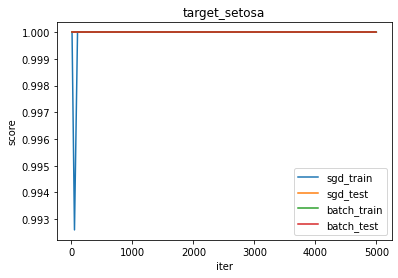

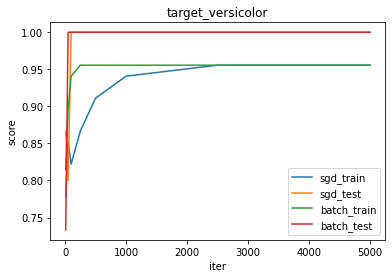

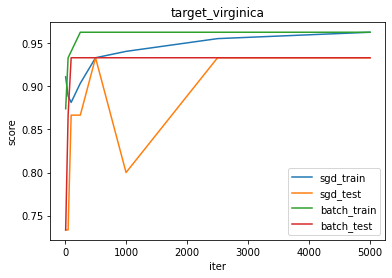

In [19]:
for cls in classes:
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].values, data[cls], test_size=0.1, random_state=42, stratify=data[cls])
    scaler = StandardScaler()
    scaler.fit(X_train[:, :-4])
    train_scaled = pd.DataFrame(scaler.transform(X_train[:, :-4]))
    test_scaled = pd.DataFrame(scaler.transform(X_test[:, :-4]))
    train_scaled = train_scaled.join(pd.DataFrame(X_train[:, -4:]), lsuffix='_l', rsuffix='_r')
    test_scaled = test_scaled.join(pd.DataFrame(X_test[:, -4:]), lsuffix='_l', rsuffix='_r')
    res_sgd_train = []
    res_batch_train = []
    res_sgd_test = []
    res_batch_test = []
    n_iter = [10, 50, 100, 250, 500, 1000, 2500, 5000]
    for num_steps in n_iter:
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(GradientDescent(descent_type='batch', num_steps =num_steps), 
                           param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kf)
        clf.fit(np.asarray(train_scaled), np.asarray(y_train))
        res_batch_train.append(clf.best_score_)
        res_batch_test.append(accuracy_score(y_test, clf.predict(test_scaled)))

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = GridSearchCV(GradientDescent(descent_type='sgd', num_steps =num_steps), 
                           param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kf)
        clf.fit(np.asarray(train_scaled), np.asarray(y_train))
        res_sgd_train.append(clf.best_score_)
        res_sgd_test.append(accuracy_score(y_test, clf.predict(test_scaled)))
      
    plt.plot(n_iter, res_sgd_train, label='sgd_train')
    plt.plot(n_iter, res_sgd_test, label='sgd_test')
    plt.plot(n_iter, res_batch_train, label='batch_train')
    plt.plot(n_iter, res_batch_test, label='batch_test')
    plt.xlabel("iter")
    plt.ylabel("score")
    plt.title(cls)
    plt.legend()
    plt.show()

На основе полученных результатов можем сделать следующие выводы:

1. SGD имеет меньшую скорость сходимость (корректировка направления движения происходит по одному объекту) в сравнени с batch GD (движение происходит в направлении антиградиента).
2. SGD требует меьших вычислительных затрат в сравнении с BGD (для обучения используется 1 объект и вся выборка соответственно).
3. За счет постоянства шага оба метода могут иметь проблемы в случаях с функционалами с большим кольчеством экстремумов. В случае большого шага будет происходить "перепрыгивание" минимума, в случае малого - медленная сходимость и "застревание" в точках локального минимума. На практике к данным методам применяются различные модификации (momentum, Adam) для устранения описанных выше недостатков.